# 08.2 Intensity-Based Credit Models
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:
- Introduce default times modelled directly via a **hazard rate** (intensity).
- Derive survival probabilities, default probabilities, and defaultable zero-coupon prices.
- Show how the intensity behaves like a **credit spread** added to the short rate.
- Derive the fair CDS spread in an intensity framework.
- Implement numerical tools: survival curve computation, defaultable ZC pricing, CDS legs and fair spread under deterministic intensity, Monte-Carlo simulation of Cox processes (stochastic intensities).

**This notebook**: 

We move from structural models (Merton, Black–Cox) to reduced-form or intensity-based credit models. In structural models, default is triggered by the firm value $V_t$ crossing a barrier. This is micro-founded (balance-sheet logic) but hard to calibrate, and default is never truly a “surprise”: if we observe $V_t$, we can anticipate distress.


# 1. From Structural to Reduced-Form Models

In structural models:

- Default is defined via the firm value $V_t$ (e.g. $V_T < L$ in Merton, or first passage to a barrier in Black–Cox).
- The driver is microeconomic: assets vs liabilities.
- Once we observe the firm value process, default is predictable (at least in continuous time): if $V_t$ drifts towards the barrier, the market "sees it coming".

In reduced-form (intensity-based) models, we change philosophy:

- We do not model the firm value explicitly.
- We model the default time $\tau$ directly as a random time with intensity $\lambda(t)$.
- Default can truly be a surprise jump, as in practice.
- The model is designed to calibrate directly to CDS term structures.

This is the standard framework for single-name CDS and credit indices.

# 2. Hazard Rate and Survival Probability

Let $\tau$ be a default time. Its hazard rate (or intensity) $\lambda(t)$ is defined by

$$
\lambda(t) = \frac{f_\tau(t)}{1 - F_\tau(t)} ,
$$

where

- $F_\tau(t) = \mathbb{P}(\tau \le t)$ is the cumulative default probability,
- $f_\tau(t)$ is the density (if it exists),
- $1 - F_\tau(t) = \mathbb{P}(\tau > t)$ is the survival probability.

From this definition, we obtain the **survival function**:

$$
\mathbb{P}(\tau > t) = S(t) = \exp\left(-\int_0^t \lambda(s)\,ds\right).
$$

- A high intensity $\lambda(t)$ means survival decays quickly.
- If $\lambda$ is constant, $S(t) = e^{-\lambda t}$.

**Construction of $\tau$ from $\lambda$** :

Given a deterministic or stochastic intensity $\lambda_t$, we can construct a default time via:

$$
\tau = \inf\left\{t \ge 0 : \int_0^t \lambda_s \, ds \ge \xi \right\}, 
\qquad \xi \sim \text{Exp}(1).
$$

This is the standard construction of a non-homogeneous Poisson (or Cox) arrival time: we integrate the intensity until the accumulated hazard exceeds an exponential trigger.

# 3. Pricing a Risky Zero-Coupon Bond

Let $r_t$ be the short rate under the risk-neutral measure $\mathbb{Q}$. The price at time $t$ of a risk-free zero-coupon maturing at $T$ is

$$
P(t,T) = \mathbb{E}^{\mathbb{Q}}\!\left[ \exp\!\left(-\int_t^T r(s)\,ds\right) \Bigm| \mathcal{F}_t \right].
$$

We consider now a defaultable zero-coupon that pays 1 at $T$ if there is no default before $T$, and some recovery if default occurs. Let $\mathcal{F}_t$ be the market filtration (rates, etc.) and $\mathcal{G}_t = \mathcal{F}_t \vee \sigma(\mathbf{1}_{\{\tau \le s\}}, s \le t)$ the enlarged filtration including default information.

The risky bond price is

$$
D(t,T) 
= \mathbb{E}^{\mathbb{Q}}\!\left[ \mathbf{1}_{\{\tau > T\}} 
\exp\!\left(-\int_t^T r(s)\,ds\right) \Bigm| \mathcal{G}_t \right].
$$

We are interested in the case before default, i.e. on $\{\tau > t\}$. Then, under standard reduced-form assumptions, we obtain

$$
D(t,T)
= \mathbb{E}^{\mathbb{Q}}\!\left[ 
\exp\!\left(-\int_t^T (r(s) + \lambda(s))\,ds\right)
\Bigm| \mathcal{F}_t \right].
$$

The intensity $\lambda(t)$ behaves like an additional short rate on top of $r(t)$. It acts as a credit spread.

**Deterministic intensity (no recovery structure yet)** : 

If both $r$ and $\lambda$ are deterministic, we can write:

$$
D(t,T)
= \exp\!\left(-\int_t^T \lambda(s)\,ds\right) P(t,T).
$$

The price of a risky ZC equals the risk-free price multiplied by the survival probability between $t$ and $T$.

# 4. Constant Intensity and Recovery

Assuming:

- Constant risk-free rate $r$,
- Constant intensity $\lambda$,
- A fractional recovery of par: if default occurs before $T$, the bond pays a fraction $R$ of notional at maturity (simple stylised model).

Then survival over $[0,T]$ is $S(T) = e^{-\lambda T}$. The risky bond pays:

- $1$ if no default ($\tau > T$),
- $R$ if default occurs before $T$.

Its time-0 value is

$$
\begin{aligned}
D(0,T)
&= e^{-rT}\left( R \, \mathbb{P}(\tau \le T) + 1 \cdot \mathbb{P}(\tau > T) \right) \\
&= e^{-rT}\left( R (1 - e^{-\lambda T}) + e^{-\lambda T} \right) \\
&= e^{-rT} \left( R + (1-R)e^{-\lambda T} \right).
\end{aligned}
$$

This closed-form formula will be implemented numerically.

We can define the credit spread $s_T$ at maturity $T$ via

$$
D(0,T) = e^{-(r + s_T) T}
\quad \Longrightarrow \quad
s_T = -\frac{1}{T} \ln\left(R + (1-R)e^{-\lambda T}\right).
$$

The spread increases with $\lambda$ and decreases with recovery $R$.

# 5. CDS Pricing with Deterministic Intensity

A CDS exchanges:

- A **premium leg** (protection buyer pays regular coupons),
- A **protection leg** (protection seller compensates the loss given default).

Let:

- $T_1, \dots, T_n$ be the payment dates,
- $\Delta_i$ the accrual year fractions,
- $s$ the CDS spread (annualised),
- $N$ the notional,
- $R$ the recovery rate, $LGD = 1-R$,
- $S(t) = \mathbb{P}(\tau > t)$ the survival probability,
- $r$ (and possibly $\lambda$) deterministic.

**Premium leg**

At each date $T_i$, the buyer pays $s N \Delta_i$ conditional on survival:

$$
\text{Prem} = N s \sum_{i=1}^n \Delta_i \, e^{-r T_i} S(T_i).
$$

**Protection leg**

The seller pays $N(1-R)$ at the default time if $\tau \le T_n$. Under deterministic $r$ and $\lambda$,

$$
\text{Prot} = N (1-R) \int_0^{T_n} e^{-r u} \lambda(u) S(u)\,du.
$$

The fair CDS spread $s$ equates the two legs:

$$
s = \frac{(1-R) \int_0^{T_n} e^{-r u} \lambda(u) S(u)\,du}
    {\sum_{i=1}^n \Delta_i \, e^{-r T_i} S(T_i)}.
$$

In practice, with deterministic $r,\lambda$ and a fixed time grid, this integral is approximated by a sum.

When both $r$ and $\lambda$ are deterministic, we often write

$$
S(u) = \exp\left(-\int_0^u \lambda(s)\,ds\right),
\quad
P(0,u) = e^{-r u},
$$

and approximate

$$
s \approx 
\frac{(1-R) \sum_j \lambda(u_j) S(u_j) P(0,u_j)\,\Delta u_j}
{\sum_i \Delta_i S(T_i) P(0,T_i)}.
$$

This is exactly what we will implement in the numerical section.

**Calibration in practice** : 

On the market, we observe CDS spreads $\{s_1, \dots, s_m\}$ for maturities $\{T_1, \dots, T_m\}$ (typically 1y, 3y, 5y, 7y, 10y).  
We invert the CDS pricing formulas to infer a survival curve $\mathbb{Q}(\tau > T)$ or an equivalent piecewise-constant intensity $\lambda(t)$ on successive intervals.

The key point is that intensity-based models are calibrated directly to CDS spreads, not to the firm value. This explains their dominant role in market practice.

# 6. Numerical Python Implementation

We now implement simple tools to illustrate the theory.

- Survival curves for deterministic intensities,
- Defaultable ZC prices under constant intensity,
- Fair CDS spread for constant intensity,
- A basic Cox-process simulation with CIR intensity.

## 6.1 Survival Curve

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def survival_curve(lam, times):
    """
    Survival curve S(t) for a deterministic intensity λ(t).

    Parameters
    ----------
    lam : float or callable
        Constant intensity (float) or function lam(t) returning λ(t).
    times : array-like
        Time grid at which to compute S(t).

    Returns
    -------
    S : np.ndarray
        Survival probabilities at each time in `times`.
    """
    times = np.array(times, dtype=float)

    # Constant intensity
    if np.isscalar(lam):
        return np.exp(-lam * times)

    # General deterministic λ(t): Euler approximation of ∫ λ(s) ds
    dt = np.diff(np.hstack(([0.0], times)))
    lam_values = lam(times)
    cum_int = np.cumsum(lam_values * dt)
    return np.exp(-cum_int)

## 6.2 Defaultable Zero-Coupon (constant λ)

In [4]:
def defaultable_zc(r, lam, R, T):
    """
    Price at t=0 of a defaultable zero-coupon with maturity T,
    constant short rate r, constant intensity λ, and fractional recovery R.

    D(0,T) = e^{-rT} [R + (1-R) e^{-λT}]
    """
    S_T = np.exp(-lam * T)
    return np.exp(-r * T) * (R + (1.0 - R) * S_T)

## 6.3 CDS Fair Spread (deterministic λ)

We implement the fair CDS spread using a discrete time grid and a (possibly constant) deterministic intensity.

In [ ]:
def cds_spread(r, lam, R, times):
    """
    Fair CDS spread for deterministic intensity λ and constant rate r.

    Parameters
    ----------
    r : float
        Constant risk-free rate.
    lam : float
        Constant intensity (for now).
    R : float
        Recovery rate.
    times : array-like
        Payment dates T_i (in years), sorted increasing.

    Returns
    -------
    s : float
        Fair CDS spread.
    """
    times = np.array(times, dtype=float)
    LGD = 1.0 - R

    # Survival under constant λ
    S = np.exp(-lam * times)

    # Year fractions Δ_i (simple forward differences)
    dt = np.diff(np.hstack(([0.0], times)))

    # Discount factors
    disc = np.exp(-r * times)

    # Protection leg ≈ ∑ LGD * λ * disc * S * dt
    prot = np.sum(LGD * lam * disc * S * dt)

    # Premium leg ≈ ∑ disc * S * dt
    prem = np.sum(disc * S * dt)

    return prot / prem

## 6.4 Simulation of a Cox Process (Stochastic Intensity)

We now simulate a Cox process where the intensity itself follows a CIR dynamics:

$$
d\lambda_t = \kappa(\theta - \lambda_t)\,dt + \eta\sqrt{\lambda_t}\,dW_t.
$$

Default occurs when the integrated intensity exceeds an exponential threshold, as described earlier.


In [ ]:
def simulate_cox_default(lam0, kappa, theta, eta, T, steps):
    """
    Simulate a single default time τ under a Cox process with CIR intensity.

    Parameters
    ----------
    lam0 : float
        Initial intensity λ_0.
    kappa : float
        Mean-reversion speed.
    theta : float
        Long-run mean of λ_t.
    eta : float
        Volatility parameter in CIR.
    T : float
        Simulation horizon.
    steps : int
        Number of time steps.

    Returns
    -------
    tau : float
        Default time (<= T) if default occurred,
        or T if no default before horizon.
    """
    dt = T / steps
    lam = lam0
    integral = 0.0
    E = np.random.exponential(1.0)  # Exp(1) trigger

    for i in range(steps):
        dW = np.sqrt(dt) * np.random.randn()
        lam = max(lam + kappa * (theta - lam) * dt + eta * np.sqrt(max(lam, 0.0)) * dW, 0.0)
        integral += lam * dt
        if integral >= E:
            return i * dt  # default time

    # No default before T
    return T

We can use this to build an empirical survival curve and compare it to a constant-λ benchmark.

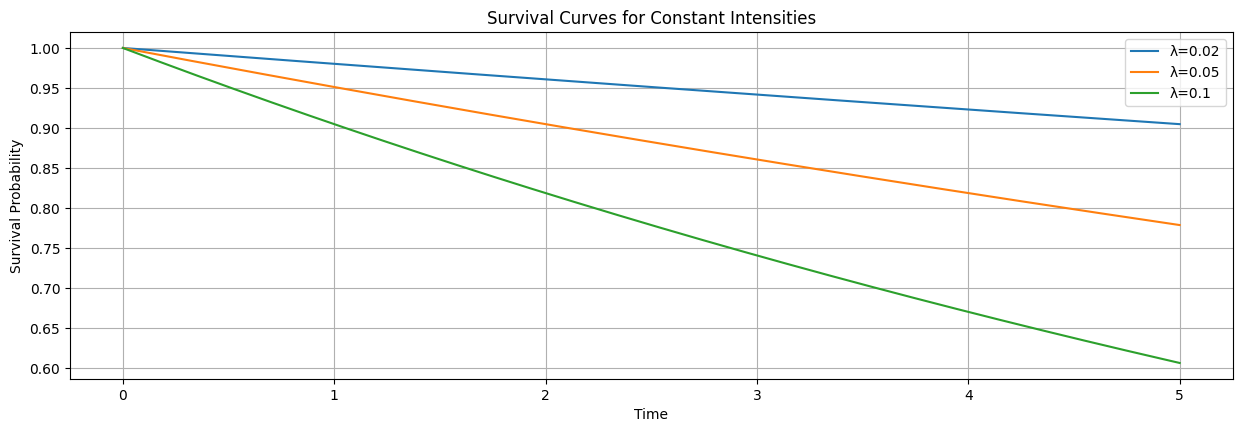

In [17]:
# Example: survival curves for constant intensities
times = np.linspace(0, 5, 200)
plt.figure(figsize=(15, 4.5))

for lam in [0.02, 0.05, 0.10]:
    S = survival_curve(lam, times)
    plt.plot(times, S, label=f"λ={lam}")

plt.title("Survival Curves for Constant Intensities")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()

The survival curves decay exponentially at a speed determined by the intensity λ: a higher λ produces a faster decline in survival probability.
Thus, λ=0.10 leads to a much steeper drop than λ=0.02, reflecting a significantly higher instantaneous default risk.

## 6.5 Illustrative Outputs: Defaultable ZC, CDS Spread, and Cox Survival

In [11]:
# Example use of defaultable_zc
for lam in [0.02, 0.05, 0.10]:
    price = defaultable_zc(r=0.02, lam=lam, R=0.4, T=5.0)
    print(f"λ={lam:.2%}, ZC(5y) price = {price:.4f}")

# Example use of cds_spread
times = [0.5, 1.0, 1.5, 2.0, 3.0, 5.0]
s = cds_spread(r=0.02, lam=0.05, R=0.4, times=times)
print(f"Fair CDS spread (λ=5%) ≈ {s:.4%}")

# Example use of simulate_cox_default
taus = [simulate_cox_default(0.05, 1.0, 0.05, 0.2, T=5.0, steps=500) for _ in range(2000)]
print(f"Empirical survival at 5y ≈ {np.mean(np.array(taus) > 5.0):.3f}")


λ=2.00%, ZC(5y) price = 0.8532
λ=5.00%, ZC(5y) price = 0.7847
λ=10.00%, ZC(5y) price = 0.6912
Fair CDS spread (λ=5%) ≈ 3.0000%
Empirical survival at 5y ≈ 0.000


The defaultable ZC prices decrease as λ increases, reflecting lower survival probabilities.  
With λ = 5% and R = 40%, the fair CDS spread is ≈ 3%, consistent with the approximation s ≈ LGD × λ.  
In the Cox simulation, the empirical survival at 5 years is nearly zero, indicating that under the chosen CIR parameters, intensity paths frequently spike high enough to trigger default before maturity.